In [42]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# from dataprep.eda import plot, plot_correlation, plot_missing

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [43]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [44]:
apt_tr = train[train['임대건물구분']=='아파트']
store_tr = train[train['임대건물구분']=='상가']

apt_test = test[test['임대건물구분']=='아파트']
store_test = test[test['임대건물구분']=='상가']

In [45]:
print(train.shape)
print(test.shape)

(2896, 34)
(1008, 33)


In [46]:
train['공가수_비율'] =  train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['공가수_비율'] =  test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

In [47]:
train['0~19 인구수'] = train['0~19세_비율']*train['총세대수']
train['20~39 인구수'] = train['20~39세_비율']*train['총세대수']
train['40~69 인구수'] = train['40~69세_비율']*train['총세대수']
train['70세이상 인구수'] = train['70세이상_비율']*train['총세대수']

In [48]:
test['0~19 인구수'] = test['0~19세_비율']*test['총세대수']
test['20~39 인구수'] = test['20~39세_비율']*test['총세대수']
test['40~69 인구수'] = test['40~69세_비율']*test['총세대수']
test['70세이상 인구수'] = test['70세이상_비율']*test['총세대수']

In [49]:
area = ['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시']
for ind in range(train.shape[0]):
    if train.loc[ind,'지역'] in area :
        train.loc[ind,'환승역 수'] = 0
train = train.join(pd.get_dummies(train['환승역 수'],prefix='sub')).iloc[:,:-1]
train = train.drop('환승역 수',axis=1)

In [50]:
for ind in range(test.shape[0]):
    if test.loc[ind,'지역'] in area :
        test.loc[ind,'환승역 수'] = 0
test = test.join(pd.get_dummies(test['환승역 수'],prefix='sub')).iloc[:,:-1]
test = test.drop('환승역 수',axis=1)

In [51]:
def func2(x):
    if x<0.005: 
        return 0
    elif 0.005<x<0.02:
        return 1
    elif 0.02<x<1:
        return 2
    elif x>1:
        return 3

In [52]:
train['sub_cat'] = train['subway_dist'].apply(lambda x : func2(x))
test['sub_cat'] = test['subway_dist'].apply(lambda x : func2(x))

In [53]:
train = train.join(pd.get_dummies(train['sub_cat'],prefix='sub_dist')).iloc[:,:-1]
train = train.drop(['subway_dist','sub_cat'],axis=1)

In [54]:
test = test.join(pd.get_dummies(test['sub_cat'],prefix='sub_dist')).iloc[:,:-1]
test = test.drop(['subway_dist','sub_cat'],axis=1)

###  공급유형 

In [55]:
def func3(x,dic):
    for i in dic.keys():
        if len(dic[i]) == len(x):
            if all(dic[i] == x):
                return i

In [56]:
# # 방안 1 

# train.loc[train['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'
# test.loc[test['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'

# no_shop = train[train['공급유형']!='임대상가']
# uniq = np.reshape(no_shop['공급유형'].unique(),(8,1))

# dic = dict(enumerate(uniq))
# dic[8] = ['장기전세', '공공임대(10년)', '공공임대(분납)']
# dic[9] = ['장기전세', '국민임대', '영구/행복']
# dic[10] = ['국민임대', '영구/행복']
# dic[11] = ['공공임대(10년)', '공공임대(분납)']
# dic[12] = ['공공분양', '공공임대(10년)', '공공임대(분납)']
# dic[13] = ['공공임대(10년)', '국민임대']
# dic[14] = ['공공임대(50년)', '영구/행복']

# # train
# no_shop = train[train['공급유형']!='임대상가']
# sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
# sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
# train = pd.merge(train,sample[['단지코드','cluster']],on='단지코드',how='left')
# train = train.join(pd.get_dummies(train['cluster'],prefix='type')).iloc[:,:-1]
# train = train.drop(['공급유형','cluster'],axis=1)

# # test
# no_shop = test[test['공급유형']!='임대상가']
# sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
# sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
# test = pd.merge(test,sample[['단지코드','cluster']],on='단지코드',how='left')
# test = test.join(pd.get_dummies(test['cluster'],prefix='type')).iloc[:,:-1]
# test = test.drop(['공급유형','cluster'],axis=1)

In [57]:
# 방안 2 

train.loc[train['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'
test.loc[test['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'

train.loc[train['공급유형'].isin(['공공임대(10년)', '공공임대(5년)']),'공급유형'] = '공공임대(단기)'
test.loc[test['공급유형'].isin(['공공임대(10년)', '공공임대(5년)']),'공급유형'] = '공공임대(단기)'

no_shop = train[train['공급유형']!='임대상가']
uniq = np.reshape(no_shop['공급유형'].unique(),(7,1))

dic = dict(enumerate(uniq))
dic[8] = ['공공임대(단기)', '국민임대']
dic[9] = ['장기전세', '국민임대', '영구/행복']
dic[10] = ['국민임대', '영구/행복']
dic[11] = ['공공임대(단기)', '공공임대(분납)']
dic[12] = ['공공분양', '공공임대(단기)', '공공임대(분납)']
dic[13] = ['공공임대(50년)', '영구/행복']
dic[14] = ['장기전세', '공공임대(단기)', '공공임대(분납)']

# train
no_shop = train[train['공급유형']!='임대상가']
sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
sample['cluster'] = sample['cluster'].apply(lambda x: int(x))
train = pd.merge(train,sample[['단지코드','cluster']],on='단지코드',how='left')
train = train.join(pd.get_dummies(train['cluster'],prefix='type')).iloc[:,:-1]
train = train.drop(['공급유형','cluster'],axis=1)

# test
no_shop = test[test['공급유형']!='임대상가']
sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
test = pd.merge(test,sample[['단지코드','cluster']],on='단지코드',how='left')
test = test.join(pd.get_dummies(test['cluster'],prefix='type')).iloc[:,:-1]
test = test.drop(['공급유형','cluster'],axis=1)
test['type_8'] = 0
test['type_9'] = 0
test['type_11'] = 0
test['type_12'] = 0
test['type_13'] = 0

# sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].nunique()).reset_index()
# ind = sample[sample['공급유형']>1]['단지코드'].values
# no_shop.loc[no_shop['단지코드'].isin(ind),:].groupby('단지코드')['공급유형'].unique()

In [58]:
dic

{0: array(['국민임대'], dtype=object),
 1: array(['공공임대(50년)'], dtype=object),
 2: array(['영구/행복'], dtype=object),
 3: array(['공공임대(단기)'], dtype=object),
 4: array(['공공임대(분납)'], dtype=object),
 5: array(['장기전세'], dtype=object),
 6: array(['공공분양'], dtype=object),
 8: ['공공임대(단기)', '국민임대'],
 9: ['장기전세', '국민임대', '영구/행복'],
 10: ['국민임대', '영구/행복'],
 11: ['공공임대(단기)', '공공임대(분납)'],
 12: ['공공분양', '공공임대(단기)', '공공임대(분납)'],
 13: ['공공임대(50년)', '영구/행복'],
 14: ['장기전세', '공공임대(단기)', '공공임대(분납)']}

In [59]:
drop = ['남/여비율','남/여_0~19세','남/여_20~39세','남/여_40~69세','남/여_70세이상','0~19세_비율','20~39세_비율','40~69세_비율','70세이상_비율']
drop1 = ['총세대수','임대건물구분','지역','공가수','자격유형','단지내주차면수','단지명','도로명주소','subway_name']

In [60]:
train = train.drop(drop,axis=1)
test = test.drop(drop,axis=1)

In [61]:
train = train.drop(drop1,axis=1)
test = test.drop(drop1,axis=1)

In [62]:
non_unique = ['전용면적','전용면적별세대수','임대보증금','임대료']
train_one = train.drop(non_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(non_unique,axis=1).drop_duplicates().reset_index(drop=True)

In [63]:
def merge(col,standard,oldDF,newDF,kind):
    sample = oldDF.groupby('단지코드').describe()[col].reset_index()
    for i in sample.index:
        for j in standard:
            code = sample.loc[i,'단지코드']
            val = sample.loc[i,j]
            ind = newDF[newDF['단지코드']==code].index
            newDF.loc[ind,kind+col+j] = val
    return newDF

In [64]:
train_one = merge('임대료',['min','25%','50%','75%','max'],apt_tr,train_one,'apt')
train_one = merge('임대보증금',['min','25%','50%','75%','max'],apt_tr,train_one,'apt')

train_one = merge('임대료',['min','25%','50%','75%','max'],store_tr,train_one,'store')
train_one = merge('임대보증금',['min','25%','50%','75%','max'],store_tr,train_one,'store')

train_one = merge('전용면적',['min','25%','50%','75%','max'],apt_tr,train_one,'apt')
train_one = merge('전용면적',['mean','std'],store_tr,train_one,'store')

train_one = train_one.replace(np.nan, 0)

In [65]:
test_one = merge('임대료',['min','25%','50%','75%','max'],apt_test,test_one,'apt')
test_one = merge('임대보증금',['min','25%','50%','75%','max'],apt_test,test_one,'apt')

test_one = merge('임대료',['min','25%','50%','75%','max'],store_test,test_one,'store')
test_one = merge('임대보증금',['min','25%','50%','75%','max'],store_test,test_one,'store')

test_one = merge('전용면적',['min','25%','50%','75%','max'],apt_test,test_one,'apt')
test_one = merge('전용면적',['mean','std'],store_test,test_one,'store')

test_one = test_one.replace(np.nan, 0)

In [66]:
print(train_one.shape)
print(test_one.shape)

(414, 57)
(147, 56)


In [67]:
train_one.corr()['등록차량수']

지하철역            -0.0069
버스정류장            0.1125
등록차량수            1.0000
연면적              0.2248
위도              -0.1013
경도               0.1240
총인구수             0.2809
세대당_인구           0.4047
공가수_비율          -0.2952
세대당_가능주차면수       0.5242
0~19 인구수         0.7024
20~39 인구수        0.6466
40~69 인구수        0.5316
70세이상 인구수        0.1033
sub_0           -0.2267
sub_1            0.2056
sub_dist_0      -0.0973
sub_dist_1       0.2296
sub_dist_2      -0.1225
type_0           0.0228
type_1          -0.1007
type_2          -0.3772
type_3           0.3672
type_8           0.0810
type_9           0.0094
type_10          0.0780
type_11         -0.0077
type_12          0.2195
type_13         -0.0460
apt임대료min        0.3813
apt임대료25%        0.4190
apt임대료50%        0.4762
apt임대료75%        0.4900
apt임대료max        0.5228
apt임대보증금min      0.3852
apt임대보증금25%      0.3968
apt임대보증금50%      0.3971
apt임대보증금75%      0.3967
apt임대보증금max      0.3511
store임대료min     -0.1197
store임대료25%     -0.1211
store임대료50%     

## 유민이 코드 추가 

In [68]:
# Fitting
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from xgboost import XGBRegressor
# import lightgbm as LGB
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error 

# Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold

In [69]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=500)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error

def fit_models(X_train1, X_test1, y_train1, y_test1, models):
    best_error = 400
    best_tst_pred = 0
    best_model = ""
    for m in models:
        model, tst_pred, error = fit(X_train1, X_test1, y_train1, y_test1, m)
        if best_error > error:
            best_error = error
            best_tst_pred = tst_pred
            best_model = model
    return best_model, best_tst_pred, best_error

In [169]:
# X_train1, X_test1, y_train1, y_test1 = train_test_split(train1_one, y1, 
#                                                     test_size=0.3, 
#                                                     random_state=2021, 
#                                                     shuffle=True)
# X_train2, X_test2, y_train2, y_test2 = train_test_split(train2_one, y2, 
#                                                     test_size=0.3, 
#                                                     random_state=2021, 
#                                                     shuffle=True)

In [29]:
train_one = train_one.drop(["apt전용면적25%","apt전용면적75%","store임대료25%","store임대료75%","store임대보증금25%","store임대보증금75%","apt임대보증금25%","apt임대보증금75%"],axis=1)
test_one = test_one.drop(["apt전용면적25%","apt전용면적75%","store임대료25%","store임대료75%","store임대보증금25%","store임대보증금75%","apt임대보증금25%","apt임대보증금75%"],axis=1)


In [30]:
tr1 = train_one[train_one.세대당_가능주차면수< 0.8304195804195804]
tr2 = train_one[train_one.세대당_가능주차면수>= 0.8304195804195804]

In [31]:
tst1 = test_one[test_one.세대당_가능주차면수< 0.8304195804195804]
tst2 = test_one[test_one.세대당_가능주차면수>= 0.8304195804195804]

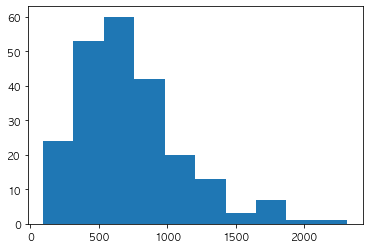

In [106]:
plt.hist(tr2.등록차량수)
plt.show()

In [97]:
tr1.shape, tr2.shape

((190, 57), (224, 57))

In [32]:
X1 = tr1.drop(['등록차량수','단지코드'],axis=1)
# y1 = tr1['등록차량수']
y1 = np.log(tr1['등록차량수'])
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3,random_state=2021,shuffle=True)

# X2 = tr2.drop(['등록차량수','단지코드'],axis=1)
# y2 = tr2['등록차량수']
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3,random_state=2021,shuffle=True)
X2 = tr2.drop(['등록차량수','단지코드'],axis=1)
y2 = np.log(tr2['등록차량수'])

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3,random_state=2021,shuffle=True)

In [33]:

models = [LinearRegression(), 
          PLSRegression(), 
          Ridge(random_state=2021),
          Lasso(random_state=2021), 
          ElasticNet(random_state=2021),
          SVR(),
          CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
          RandomForestRegressor(criterion="mae",random_state=2021),
          GradientBoostingRegressor(criterion="mae",random_state=2021),
#           XGBRegressor(random_state=2021)
         ]

best_model1, best_tst_pred1, best_error1 = fit_models(X_train1, X_test1, y_train1, y_test1, models)
print(best_model1, best_error1)

best_model2, best_tst_pred2, best_error2 = fit_models(X_train2, X_test2, y_train2, y_test2, models)
print(best_model2, best_error2)

0:	learn: 0.6937838	total: 63.2ms	remaining: 1m 3s
500:	learn: 0.0253332	total: 598ms	remaining: 595ms
999:	learn: 0.0055453	total: 1.15s	remaining: 0us
GradientBoostingRegressor(criterion='mae', random_state=2021) 0.2993082859958314
0:	learn: 0.4248804	total: 1.36ms	remaining: 1.36s
500:	learn: 0.0229906	total: 562ms	remaining: 560ms
999:	learn: 0.0066274	total: 1.1s	remaining: 0us
<catboost.core.CatBoostRegressor object at 0x7f914b9d8ee0> 0.22113174269503366


In [40]:
mean_absolute_error(np.exp(best_tst_pred1),np.exp(y_test1)), mean_absolute_error(np.exp(best_tst_pred2),np.exp(y_test2))

(117.4750146963447, 166.59147728406057)

In [41]:
117.4750146963447*(3/4)+166.59147728406057*(1/4)

129.75413034327366

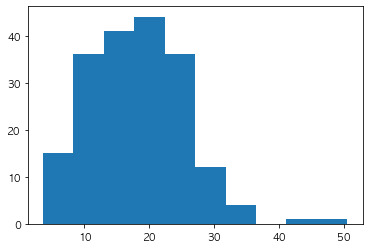

In [39]:
plt.hist(np.sqrt(tr1['등록차량수']))
plt.show()

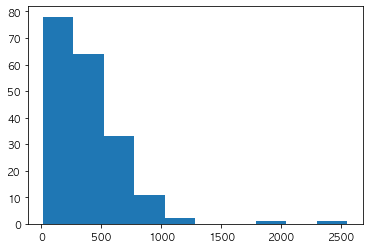

In [37]:
plt.hist((tr1['등록차량수']))
plt.show()

In [124]:
y2 = np.sqrt(tr2['등록차량수'])

In [127]:

models = [LinearRegression(), 
          PLSRegression(), 
          Ridge(random_state=2021),
          Lasso(random_state=2021), 
          ElasticNet(random_state=2021),
          SVR(),
          CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
          RandomForestRegressor(criterion="mae",random_state=2021),
          GradientBoostingRegressor(criterion="mae",random_state=2021),
#           XGBRegressor(random_state=2021)
         ]

best_model1, best_tst_pred1, best_error1 = fit_models(X_train1, X_test1, y_train1, y_test1, models)
print(best_model1, best_error1)

best_model2, best_tst_pred2, best_error2 = fit_models(X_train2, X_test2, y_train2, y_test2, models)
print(best_model2, best_error2)

0:	learn: 0.6946401	total: 1.71ms	remaining: 1.71s
500:	learn: 0.0297361	total: 596ms	remaining: 594ms
999:	learn: 0.0065723	total: 1.21s	remaining: 0us
GradientBoostingRegressor(criterion='mae', random_state=2021) 0.25810867602285437
0:	learn: 0.4249539	total: 1.39ms	remaining: 1.39s
500:	learn: 0.0184059	total: 604ms	remaining: 601ms
999:	learn: 0.0058180	total: 1.19s	remaining: 0us
<catboost.core.CatBoostRegressor object at 0x7fdd683244f0> 0.21545789705484206


In [128]:
tst1 = test_one[test_one.세대당_가능주차면수< 0.8304195804195804]
tst2 = test_one[test_one.세대당_가능주차면수>= 0.8304195804195804]

In [ ]:
gb = GradientBoostingRegressor(criterion="mae",random_state=2021)
gb = gb.fit(X_train1,y_train1)
real_x1 = tst1.drop('단지코드',axis=1)
np.exp(gb.predict(real_x1))

In [185]:
gb = GradientBoostingRegressor(criterion="mae",random_state=2021)
gb = gb.fit(X_train1,y_train1)
real_x1 = tst1.drop('단지코드',axis=1)
real_y1 = np.exp(gb.predict(real_x1))


cb = CatBoostRegressor(random_state=2021, loss_function = 'MAE')
cb = cb.fit(X_train2,y_train2,verbose=False)
real_x2 = tst2.drop('단지코드',axis=1)
real_y2 = np.exp(cb.predict(real_x2))


In [186]:
tmp1 = pd.concat([pd.DataFrame(tst1.단지코드),pd.DataFrame(tst2.단지코드)],axis=0).reset_index(drop=True)
tmp2 = pd.concat([pd.DataFrame(real_y1),pd.DataFrame(real_y2)],axis=0).reset_index(drop=True)
tmp1.shape, tmp2.shape
tmpp = pd.concat([tmp1,tmp2],axis=1)

In [187]:
real_y = tmpp[0] 

In [188]:
gb = GradientBoostingRegressor(criterion="mae",random_state=2021)
gb = gb.fit(X1,y1)
real_x1 = tst1.drop('단지코드',axis=1)
real_y1 = np.exp(gb.predict(real_x1))


cb = CatBoostRegressor(random_state=2021, loss_function = 'MAE')
cb = cb.fit(X2,y2,verbose=False)
real_x2 = tst2.drop('단지코드',axis=1)
real_y2 = np.exp(cb.predict(real_x2))


123

In [77]:
from sklearn.linear_model import LinearRegression

In [118]:

models = [LinearRegression(), 
#           PLSRegression(), 
#           Ridge(random_state=2021),
#           Lasso(random_state=2021) 
#           ElasticNet(random_state=2021),
#           SVR(),
#           CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
#           RandomForestRegressor(criterion="mae",random_state=2021),
#           GradientBoostingRegressor(criterion="mae",random_state=2021),
#           XGBRegressor(random_state=2021)
         ]

best_model1, best_tst_pred1, best_error1 = fit_models(X_train1, X_test1, y_train1, y_test1, models)
print(best_model1, best_error1)

best_model2, best_tst_pred2, best_error2 = fit_models(X_train2, X_test2, y_train2, y_test2, models)
print(best_model2, best_error2)

LinearRegression() 129.08318509392072
LinearRegression() 2.98850360478561


In [137]:
def myfunc():
    cb = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/EDA_CYR/0713_cb.csv")
    cb = cb.loc[-cb['code'].isin(['C2675', 'C2335', 'C1327']),:].reset_index(drop=True)
    return cb

In [189]:
res = myfunc()
mae(real_y,res['num'])

333.7329012645621

In [139]:
# result = pd.concat([te.단지코드.reset_index(drop=True), pd.DataFrame(tst_predict)],axis=1)
tmpp.columns = ["code","num"]
sample = pd.read_csv("/Users/seungji/Desktop/Dacon/parking_data/sample_submission.csv")
sub = sample.merge(tmpp, left_on = "code", right_on = "code",how = "left")
sub = sub[["code","num_y"]]
sub.columns = ["code","num"]
sub.loc[sub.num<0,"num"] = np.min(sub.loc[sub.num>=0,"num"])
sub.to_csv("sub0717_0.278.csv",index=False)

In [150]:
gb = GradientBoostingRegressor(criterion="mae",random_state=2021)
gb = gb.fit(X1,y1)
real_x1 = tst1.drop('단지코드',axis=1)
real_y1 = np.exp(gb.predict(real_x1))


lm = LinearRegression()
lm = lm.fit(X2,y2)
real_x2 = tst2.drop('단지코드',axis=1)
real_y2 = np.exp(lm.predict(real_x2))


In [196]:
X2.shape

(224, 47)

In [197]:
tst2.shape

(76, 48)

In [ ]:
lm2 = LinearRegression()
lm2 = lm2.fit(X2,y2)
real_x2 = tst2.drop('단지코드',axis=1)

In [198]:
lm1 = LinearRegression()
lm1 = lm1.fit(X1,y1)
real_x1 = tst1.drop('단지코드',axis=1)
real_y1 = np.exp(lm1.predict(real_x1))


lm2 = LinearRegression()
lm2 = lm2.fit(X2,y2)
real_x2 = tst2.drop('단지코드',axis=1)
real_y2 = np.exp(lm2.predict(real_x2))


In [203]:
lm1 = GradientBoostingRegressor(criterion="mae",random_state=2021)
lm1 = lm1.fit(X1,y1)
real_x1 = tst1.drop('단지코드',axis=1)
real_y1 = np.exp(lm1.predict(real_x1))


lm2 =GradientBoostingRegressor(criterion="mae",random_state=2021)
lm2 = lm2.fit(X2,y2)
real_x2 = tst2.drop('단지코드',axis=1)
real_y2 = np.exp(lm2.predict(real_x2))


In [204]:
tmp1 = pd.concat([pd.DataFrame(tst1.단지코드),pd.DataFrame(tst2.단지코드)],axis=0).reset_index(drop=True)
tmp2 = pd.concat([pd.DataFrame(real_y1),pd.DataFrame(real_y2)],axis=0).reset_index(drop=True)
tmp1.shape, tmp2.shape
tmpp = pd.concat([tmp1,tmp2],axis=1)
real_y = tmpp[0] 

In [205]:
def myfunc():
    cb = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/EDA_CYR/0713_cb.csv")
    cb = cb.loc[-cb['code'].isin(['C2675', 'C2335', 'C1327']),:].reset_index(drop=True)
    return cb

In [206]:
res = myfunc()
mae(real_y,res['num'])

346.0315870417631

In [154]:
gb = GradientBoostingRegressor(criterion="mae",random_state=2021)
gb = gb.fit(X1,y1)
real_x1 = tst1.drop('단지코드',axis=1)
real_y1 = np.exp(gb.predict(real_x1))


lm = LinearRegression()
lm = lm.fit(X2,y2)
real_x2 = tst2.drop('단지코드',axis=1)
real_y2 = np.exp(cb.predict(real_x2))


하나 130

In [ ]:
tmp1 = pd.concat([pd.DataFrame(tst1.단지코드),pd.DataFrame(tst2.단지코드)],axis=0).reset_index(drop=True)
tmp2 = pd.concat([pd.DataFrame(real_y1),pd.DataFrame(real_y2)],axis=0).reset_index(drop=True)
tmp1.shape, tmp2.shape
tmpp = pd.concat([tmp1,tmp2],axis=1)
real_y = tmpp[0] 

In [207]:
# result = pd.concat([te.단지코드.reset_index(drop=True), pd.DataFrame(tst_predict)],axis=1)
tmpp.columns = ["code","num"]
sample = pd.read_csv("/Users/seungji/Desktop/Dacon/parking_data/sample_submission.csv")
sub = sample.merge(tmpp, left_on = "code", right_on = "code",how = "left")
sub = sub[["code","num_y"]]
sub.columns = ["code","num"]
sub.loc[sub.num<0,"num"] = np.min(sub.loc[sub.num>=0,"num"])
sub.to_csv("717_gb.csv",index=False)

In [147]:
gb = GradientBoostingRegressor(criterion="mae",random_state=2021)
gb = gb.fit(X_train1,y_train1)
real_x1 = tst1.drop('단지코드',axis=1)
real_y1 = np.exp(gb.predict(real_x1))


lm = LinearRegression()
lm = lm.fit(X_train2,y_train2)
real_x2 = tst2.drop('단지코드',axis=1)
real_y2 = np.exp(lm.predict(real_x2))


In [148]:
tmp1 = pd.concat([pd.DataFrame(tst1.단지코드),pd.DataFrame(tst2.단지코드)],axis=0).reset_index(drop=True)
tmp2 = pd.concat([pd.DataFrame(real_y1),pd.DataFrame(real_y2)],axis=0).reset_index(drop=True)
tmp1.shape, tmp2.shape
tmpp = pd.concat([tmp1,tmp2],axis=1)
real_y = tmpp[0] 

In [149]:
res = myfunc()
mae(real_y,res['num'])

357.56693717702

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae

from catboost import CatBoostRegressor

In [39]:
X1 = tr1.drop(['등록차량수','단지코드'],axis=1)
y1 = tr1['등록차량수']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3,random_state=2021,shuffle=True)

cb1 = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(X_train1, y_train1)
pred1 = cb1.predict(X_test1)


X2 = tr2.drop(['등록차량수','단지코드'],axis=1)
y2 = tr2['등록차량수']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3,random_state=2021,shuffle=True)

cb2 = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(X_train2, y_train2)
pred2 = cb2.predict(X_test2)

mae(pred1,y_test1), mae(pred2,y_test2) 

(117.04822665513714, 161.16982752079235)

In [78]:
X1 = tr1.drop(['등록차량수','단지코드'],axis=1)
y1 = tr1['등록차량수']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3,random_state=2021,shuffle=True)

LinearRegression(X_train1)

LinearRegression(fit_intercept=      지하철역   버스정류장        연면적       위도      경도        총인구수  세대당_인구  공가수_비율  \
49  0.0000  4.0000   214.7300 128.0881 34.9399 15,428.0000  2.1200  0.0000   
48  0.0000  1.0000 2,242.5000 126.9251 36.2819 19,868.0000  2.0400  0.0051   
376 0.0000  3.0000   613.9100 127.4973 34.9879 12,674.0000  2.0300  0.0110   
379 0.0000  2.0000 4,134.8600 129.3399 35.5200 19,364.6667  2.4433  0.1300   
358 0.0000  3.0000 6,129.5500 128.7162 35.1556...
358     25.3000     26.8650     35.0000     46.9400         0.0000   
..          ...         ...         ...         ...            ...   
220     41.6700     46.7100     46.7100     46.7100         0.0000   
265     44.0300     46.4850     47.7825     51.6000         0.0000   
83      36.9200     39.8900     39.8900     46.8900         0.0000   
153     36.6300     41.4250     46.2200     46.2200         0.0000   
234     51.8750     55.7250     59.5700     59.5700         0.0000   

     store전용면적std  
49         0.0000 

<AxesSubplot:>

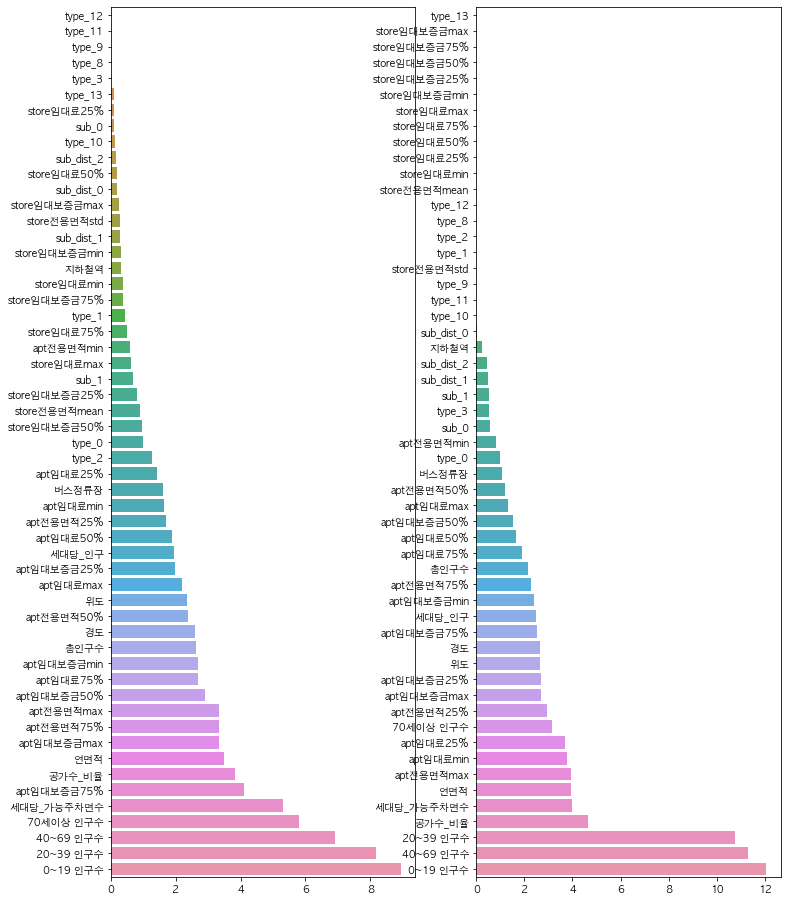

In [40]:
plt.figure(figsize=(12,16))
plt.subplot(1,2,1)
sns.barplot(y = X_train1.columns[np.argsort(cb1.feature_importances_)], x = list(cb1.feature_importances_[np.argsort(cb1.feature_importances_)]))
plt.subplot(1,2,2)
sns.barplot(y = X_train2.columns[np.argsort(cb2.feature_importances_)], x = list(cb2.feature_importances_[np.argsort(cb2.feature_importances_)]))

In [43]:
tst1 = tst1.rename(columns={'type8':'type_8','type9':'type_9','type11':'type_11','type12':'type_12','type13':'type_13'})
tst2 = tst2.rename(columns={'type8':'type_8','type9':'type_9','type11':'type_11','type12':'type_12','type13':'type_13'})

In [44]:
real_x1 = tst1.drop('단지코드',axis=1)
real_y1 = cb1.predict(real_x1)

real_x2 = tst2.drop('단지코드',axis=1)
real_y2 = cb2.predict(real_x2)

In [66]:
tmp1 = pd.concat([pd.DataFrame(tst1.단지코드),pd.DataFrame(tst2.단지코드)],axis=0).reset_index(drop=True)
tmp2 = pd.concat([pd.DataFrame(real_y1),pd.DataFrame(real_y2)],axis=0).reset_index(drop=True)
tmp1.shape, tmp2.shape
tmpp = pd.concat([tmp1,tmp2],axis=1)

((147, 1), (147, 1))

In [68]:
tmpp = pd.concat([tmp1,tmp2],axis=1)

In [74]:
real_y = tmpp[0] 

In [49]:
tst1

,단지코드,지하철역,버스정류장,연면적,위도,경도,총인구수,세대당_인구,공가수_비율,세대당_가능주차면수,0~19 인구수,20~39 인구수,40~69 인구수,70세이상 인구수,sub_0,sub_1,sub_dist_0,sub_dist_1,sub_dist_2,type_0,...,apt임대보증금50%,apt임대보증금75%,apt임대보증금max,store임대료min,store임대료25%,store임대료50%,store임대료75%,store임대료max,store임대보증금min,store임대보증금25%,store임대보증금50%,store임대보증금75%,store임대보증금max,apt전용면적min,apt전용면적25%,apt전용면적50%,apt전용면적75%,apt전용면적max,store전용면적mean,store전용면적std
6,C1794,0.0000,2,"5,712.5740",126.7232,35.9629,"55,531.0000",2.6400,0.0185,0.8139,346.4387,340.4870,581.4710,80.6033,1,0,0,0,1,1,...,"20,200,000.0000","23,086,000.0000","33,475,000.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,29.9100,39.6300,43.2650,46.9000,59.8900,0.0000,0.0000
8,C1377,0.0000,4,"5,196.4470",128.6955,34.8378,"8,014.0000",2.0500,0.0383,0.8170,68.9693,87.2086,253.5912,60.2308,1,0,0,0,1,1,...,"16,789,000.0000","68,696,000.0000","85,387,000.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,29.9100,36.6300,46.7600,46.9000,51.9300,0.0000,0.0000
9,C2072,0.0000,1,"7,014.9630",127.8965,34.8329,"13,170.0000",2.1000,0.0170,0.7932,60.0663,70.8412,164.4921,57.6004,1,0,0,0,0,1,...,"11,456,500.0000","16,102,000.0000","19,819,000.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,33.6100,33.6925,40.2600,48.0825,51.9300,0.0000,0.0000
10,C1472,0.0000,1,"6,066.1810",127.0911,36.2118,"16,173.0000",2.2200,0.0036,0.8066,102.7013,111.8160,262.7676,70.7151,1,0,0,0,1,1,...,"13,731,000.0000","13,731,000.0000","18,726,000.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,36.6200,39.5100,46.7900,46.9000,51.9300,0.0000,0.0000
11,C1006,2.0000,5,102.6500,127.3706,36.3635,"15,925.3333",2.1467,0.0179,0.2844,233.2347,425.3918,705.6893,140.6842,0,1,0,1,0,0,...,"5,787,000.0000","6,330,000.0000","11,574,000.0000","249,200.0000","455,574.7019","461,710.0000","523,174.5924","38,188,330.8719","9,700,000.0000","16,621,000.0000","17,007,055.7600","18,551,295.2187","87,876,767.9959",26.3700,26.3700,26.3700,28.8450,52.7400,71.4115,120.9518
13,C1311,0.0000,2,802.9130,129.0274,35.1703,"15,025.3333",2.2333,0.0052,0.6919,51.0230,90.6774,189.0444,52.2551,0,1,0,1,0,0,...,"17,317,000.0000","17,348,000.0000","17,354,000.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,39.7000,39.7675,39.8200,39.8550,39.8700,0.0000,0.0000
14,C2676,0.0000,2,6.8300,129.0018,35.1833,"19,510.0000",1.9250,0.0097,0.1625,277.3700,559.8154,"1,348.2896",386.5251,0,1,0,1,0,0,...,"5,787,000.0000","6,330,000.0000","6,873,000.0000","52,100.0000","129,200.0000","360,453.0278","619,610.5010","38,188,330.8719","680,000.0000","5,700,771.5625","18,124,081.7592","31,684,040.7623","87,876,767.9959",26.3700,26.3700,26.3700,28.8450,31.3200,55.6756,100.6880
15,C2318,2.0000,8,293.0280,129.1700,35.1737,"22,475.5000",2.4650,0.0024,0.5000,72.7345,108.8472,195.1251,43.2931,0,1,0,1,0,0,...,"21,801,000.0000","21,801,000.0000","21,801,000.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,49.9400,49.9400,49.9400,49.9400,49.9400,0.0000,0.0000
16,C1603,0.0000,10,"2,730.7600",126.5607,33.2631,"13,624.5000",2.2500,0.0000,0.8156,125.9717,132.4670,280.1115,63.4498,1,0,0,0,0,1,...,"18,581,000.0000","19,355,250.0000","21,678,000.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,39.6300,45.0825,47.1550,48.5400,51.9300,0.0000,0.0000
17,C2523,0.0000,13,"4,961.2340",128.5714,38.1889,"16,935.0000",2.0400,0.0054,0.7574,69.5557,90.8495,172.9909,37.6039,1,0,0,0,1,1,...,"21,442,000.0000","23,717,000.0000","25,992,000.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,36.6500,41.7750,46.9000,49.4150,51.9300,0.0000,0.0000


In [70]:
def myfunc():
    cb = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/EDA_CYR/0713_cb.csv")
    cb = cb.loc[-cb['code'].isin(['C2675', 'C2335', 'C1327']),:].reset_index(drop=True)
    return cb

In [75]:
res = myfunc()
mae(real_y,res['num'])

335.94934035148424

In [79]:
res['new_y'] = real_y
res.head()

,code,num,new_y
0,C1072,682.5972,713.9517
1,C1128,"1,171.7943",411.7711
2,C1456,530.1717,338.7369
3,C1840,528.1426,506.3528
4,C1332,"1,119.5004",161.2557


In [ ]:
result = pd.read_csv("data/result.csv")
result['y2'] = real_y

result.to_csv("data/result.csv",index=False)

In [36]:
train_one.to_csv("data/train2.csv",index=False)
test_one.to_csv("data/test2.csv",index=False)

In [81]:
tmpp

,단지코드,0
0,C1794,713.9517
1,C1377,411.7711
2,C2072,338.7369
3,C1472,506.3528
4,C1006,161.2557
...,...,...
142,C1496,738.2211
143,C1289,304.2750
144,C2551,679.7900
145,C2451,594.0959


In [84]:
# result = pd.concat([te.단지코드.reset_index(drop=True), pd.DataFrame(tst_predict)],axis=1)
tmpp.columns = ["code","num"]
sample = pd.read_csv("/Users/seungji/Desktop/Dacon/parking_data/sample_submission.csv")
sub = sample.merge(tmpp, left_on = "code", right_on = "code",how = "left")
sub = sub[["code","num_y"]]
sub.columns = ["code","num"]
sub.loc[sub.num<0,"num"] = np.min(sub.loc[sub.num>=0,"num"])
sub.to_csv("sub0717.csv",index=False)